In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Sun Apr 20 16:22:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P3             11W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import contextlib
from datetime import datetime
from IPython import get_ipython

In [5]:
import sys
sys.path.append('../../../utils')  # Add the folder to the path
from notebook_saver import NotebookSaver

In [6]:
run_start_index = len(get_ipython().user_ns['In'])

# References: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_micro\dwt_training_picture"
CATEGORIES = ["clap", "punching", "pushpull", "rubhand", "waving"]

notebook_saver = NotebookSaver()
save_dir = notebook_saver.get_save_dir()

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        break
    break 

Save directory created: notebook_versions\20250420_162223_notebookversion


In [7]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

In [8]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

print(len(training_data))

100%|██████████| 1210/1210 [00:02<00:00, 405.51it/s]

6094


In [9]:
import random

random.shuffle(training_data)

In [10]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [11]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [13]:
X = X/255.0
y = to_categorical(y, num_classes=5)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
cnn = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [16]:
cnn.compile(Adam(learning_rate = 0.0001),  
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
history = cnn.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

val_loss, val_acc = cnn.evaluate(X_val, y_val) 
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/5
39/39 [==============================] - 40s 235ms/step - loss: 9.1582 - accuracy: 0.2650 - val_loss: 8.7654 - val_accuracy: 0.3642
Epoch 2/5
39/39 [==============================] - 1s 33ms/step - loss: 8.4193 - accuracy: 0.3988 - val_loss: 8.0472 - val_accuracy: 0.4118
Epoch 3/5
39/39 [==============================] - 1s 31ms/step - loss: 7.7185 - accuracy: 0.4156 - val_loss: 7.3706 - val_accuracy: 0.4315
Epoch 4/5
39/39 [==============================] - 1s 31ms/step - loss: 7.0662 - accuracy: 0.4098 - val_loss: 6.7410 - val_accuracy: 0.4241
Epoch 5/5
39/39 [==============================] - 1s 11ms/step - loss: 6.1485 - accuracy: 0.4545
Final Validation Accuracy: 0.4544708728790283


Plot saved to: notebook_versions\20250420_162223_notebookversion\plot_20250420_162334.png


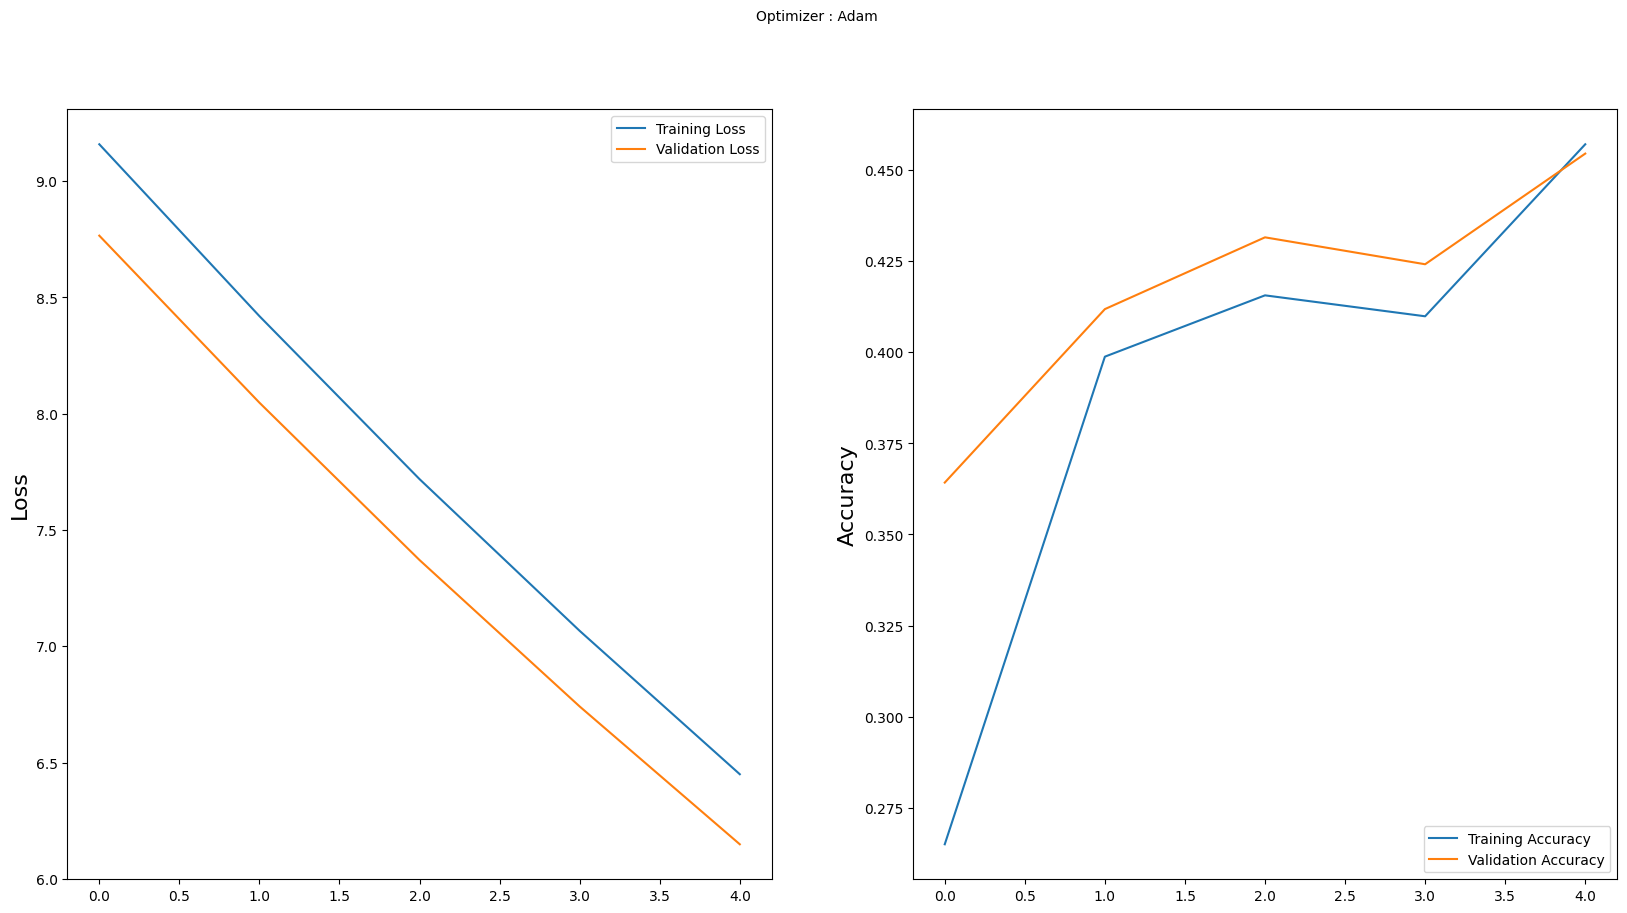

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
notebook_saver.save_plot(name = 'plot')
plt.show()

39/39 [==============================] - 1s 7ms/step
Plot saved to: notebook_versions\20250420_162223_notebookversion\cm_20250420_162343.png


<Figure size 640x480 with 0 Axes>

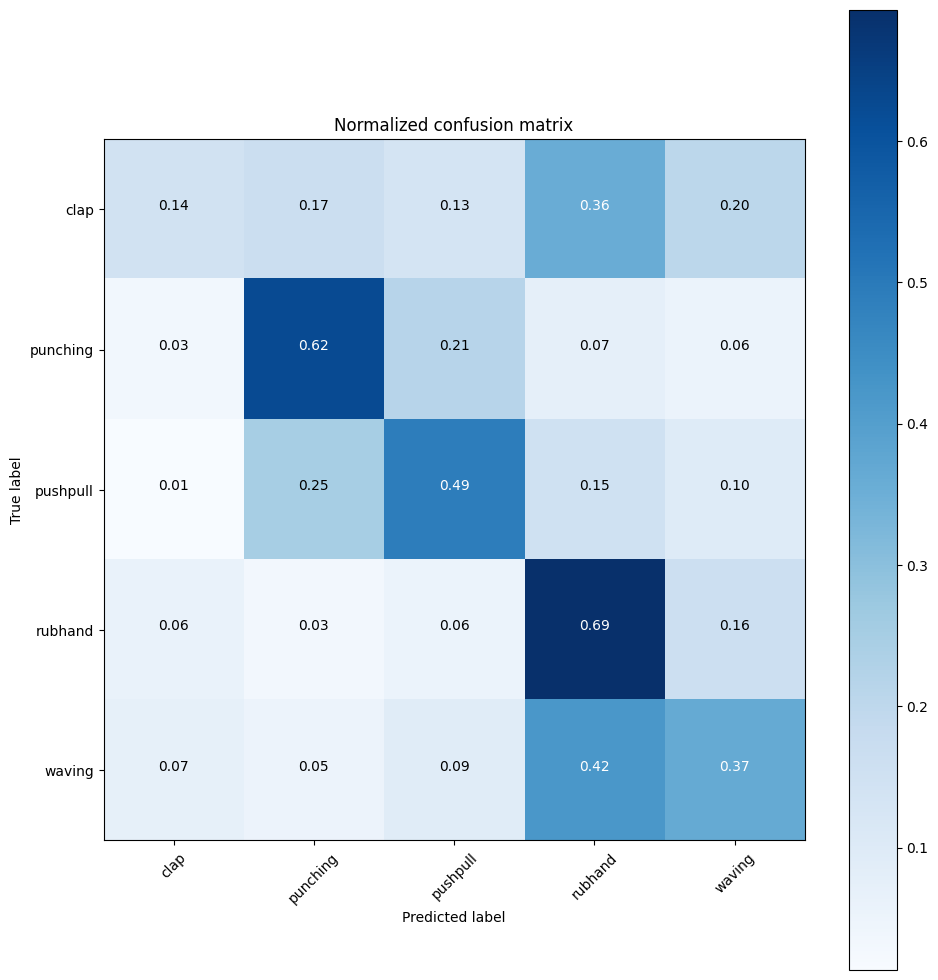

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

In [20]:
# Plot confusion matrix:
# Get predictions from the model on the validation set
y_pred_probs = cnn.predict(X_val)

y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_val, axis=1)

# Reference: https://github.com/parisafm/CSI-HAR-Dataset/blob/main/CNN.py
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    notebook_saver.save_plot(name = 'cm')

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=CATEGORIES, title='Normalized confusion matrix')
plt.show()

cnn.summary()

In [21]:
report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        clap       0.48      0.14      0.22       277
    punching       0.54      0.62      0.58       233
    pushpull       0.47      0.49      0.48       225
     rubhand       0.42      0.69      0.52       254
      waving       0.39      0.37      0.38       230

    accuracy                           0.45      1219
   macro avg       0.46      0.46      0.44      1219
weighted avg       0.46      0.45      0.43      1219



In [22]:
notebook_saver.save_notebook_code(run_start_index)
notebook_saver.save_model_summary(cnn)
notebook_saver.save_training_output(history, val_loss, val_acc)

Current notebook cell saved to: notebook_versions\20250420_162223_notebookversion\notebook_code_snapshot.py
Model summary saved to: notebook_versions\20250420_162223_notebookversion\model_summary.txt
Training output saved to: notebook_versions\20250420_162223_notebookversion\training_output.txt
